In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error

In [2]:
# Fonction test (FEM)
def branin(x):
    x1 = x[:, 0]  # première colonne de tous les points
    x2 = x[:, 1]
    return (x2 - (5.1/(4*np.pi**2))*x1**2 + 5*x1/np.pi - 6)**2 \
           + 10*(1-1/(8*np.pi))*np.cos(x1) + 10

In [3]:
# x1 in [-5, 10] - x2 in [0,15]
bounds = np.array([[-5, 10], [0, 15]])

In [4]:
# LHS 
def generate_lhs(n_samples):
    sampler = qmc.LatinHypercube(d=2)
    X = sampler.random(n=n_samples)  # Génère des points entre 0 et 1
    X_scaled = bounds[:, 0] + X * (bounds[:, 1] - bounds[:, 0])  # Mise à l’échelle
    return X_scaled

In [5]:
def build_kriging(X, y):
    model = OrdinaryKriging(
        # Coordonnées des points
        X[:, 0],  
        X[:, 1],
        # Valeurs FEM associées
        y,
        # Corrélation spatiale
        variogram_model='gaussian',
        verbose=False
    )
    return model

In [6]:
def create_validation_grid(n=50):
    x1 = np.linspace(bounds[0,0], bounds[0,1], n)
    x2 = np.linspace(bounds[1,0], bounds[1,1], n)
    X1, X2 = np.meshgrid(x1, x2)
    grid = np.column_stack([X1.ravel(), X2.ravel()])
    return X1, X2, grid

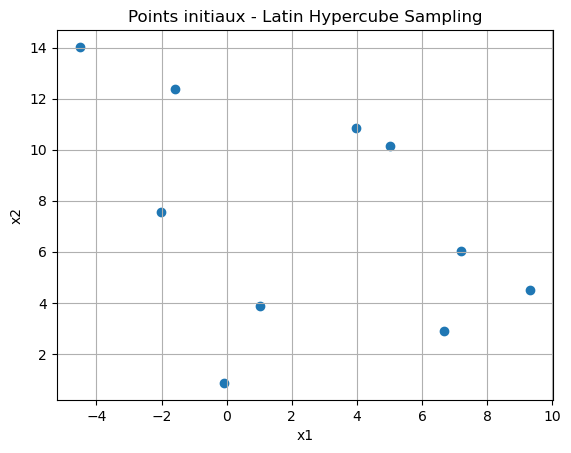

In [7]:
# On commence avec 10 points choisis avec LHS.
n_initial = 10
n_iterations = 10

X = generate_lhs(n_initial)
y = branin(X)


plt.figure()

plt.scatter(X[:,0], X[:,1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Points initiaux - Latin Hypercube Sampling")
plt.grid()
plt.show()
errors = []
n_points = []



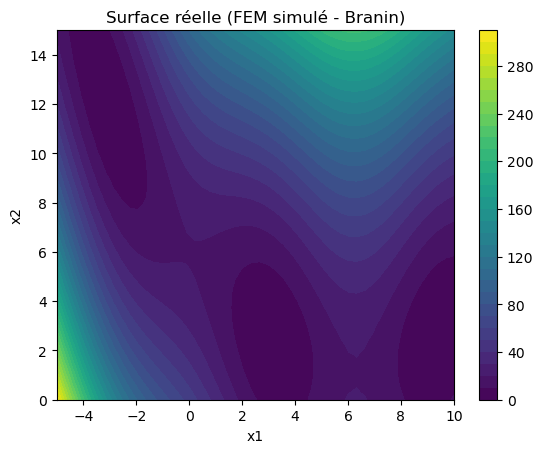

In [11]:
X1, X2, grid = create_validation_grid()
y_true = branin(grid)

Z_true = y_true.reshape(X1.shape)

plt.figure()
plt.contourf(X1, X2, Z_true, levels=30)
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Surface réelle (FEM simulé - Branin)")
plt.show()



In [12]:
for i in range(n_iterations):

    model = build_kriging(X, y)
    z_pred, ss = model.execute('points', grid[:,0], grid[:,1])
    # ss = variance (incertitude) prédite par le modèle pour chaque point de la grille
    
    rmse = np.sqrt(mean_squared_error(y_true, z_pred))
    errors.append(rmse)
    n_points.append(len(X))

    # Sélection du point le plus incertain
    idx = np.argmax(ss) 
    # on ajoute 1 point à chaque itération où le modèle est le plus incertain
    new_point = grid[idx].reshape(1, -1)

    new_value = branin(new_point)

    X = np.vstack((X, new_point))
    y = np.append(y, new_value)

    print(f"Iteration {i+1}, Points: {len(X)}, RMSE: {rmse:.4f}")

Iteration 1, Points: 11, RMSE: 49.6218
Iteration 2, Points: 12, RMSE: 36.0319
Iteration 3, Points: 13, RMSE: 21.4010
Iteration 4, Points: 14, RMSE: 20.4235
Iteration 5, Points: 15, RMSE: 20.6160
Iteration 6, Points: 16, RMSE: 20.9288
Iteration 7, Points: 17, RMSE: 22.0730
Iteration 8, Points: 18, RMSE: 20.8121
Iteration 9, Points: 19, RMSE: 19.8667
Iteration 10, Points: 20, RMSE: 20.4096


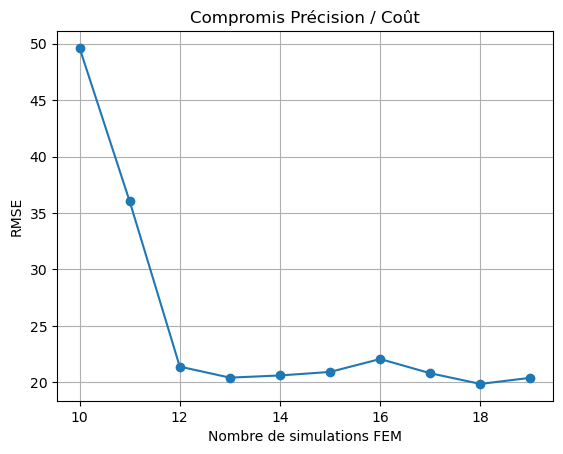

In [13]:
plt.figure()
plt.plot(n_points, errors, marker='o')
plt.xlabel("Nombre de simulations FEM")
plt.ylabel("RMSE")
plt.title("Compromis Précision / Coût")
plt.grid()
plt.show()